**Full Name: Hamidreza Amirzadeh**

**Student Number: 401206999**


# Convolutional Neural Networks
I this notebook, you'll get familiar with the implementation of CNNs by building and training two CNN networks.

## Preparing the Data
For this taks, you're going to use the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR10 is a collection of 32 * 32 images in 10 classes. Each image in CIFAR10 has three channels (RGB). You are going to download and prepare the dataset manually.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_url
from sklearn.model_selection import train_test_split
from torchvision.io import read_image

**For this question, it's highly recommended to use a CUDA-enabled environment.**
We'll check for the availability of GPU and set `device` accordingly.

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

In [3]:
url = "http://dl.dropboxusercontent.com/s/dywydpafhaamquw/cifar10.zip"
# Download the dataset using Torchvision's  `download_url`
#############################
# Your code goes here (1 point)
download_url(url, './')
#############################
!unzip -qq "./cifar10.zip"

100%|██████████| 145997066/145997066 [00:08<00:00, 17554305.66it/s]


Now you are going to implement a custom dataset class for the data you've downloaded. You can implement a custom dataset by inheriting from PyTorch's `Dataset` class. You'll then have to override `__init__`, `__len__`, and `__getitem__` functinos in your custom class. One of the advantages of defining a custom dataset like this is that you have complete control over the data that the dataset returns.

The the dataset you've downloaded has the following structure:
```
cifar10/
    test/
        img_file1.png
        img_file2.png
        ..
        ..
        annotation.csv
    train/
        img_file1.png
        img_file2.png
        ...
        ...
        annotation.csv
```

The `annotation.csv` file in each directory contains a complete list of file names and labels for all the image files in that directory. **Keep in mind that the csv files provided have no header information**.

In [4]:
class CustomCifarDataset(Dataset):
    def __init__(self, annotations_file, root_dir, transform=None):
        """
        `annotation_file`: Path to the csv file with annotations.
        `root_dir`: Directory with all the images.
        `transform`: Transform to be applied.
        """
        self.root_dir = root_dir
        self.transform = transform
        # Read the csv annotation file using pandas' `read_csv` function.
        # (The annotation file consists of n rows. Each row is in the format 
        #    img_file_name, img_label
        #  For example:
        #    airplane_1001, 0
        # )
        #############################
        # Your code goes here (2 points)
        self.annotations_file = pd.read_csv(annotations_file, header=None)
        #############################

    def __len__(self):
        # Return the number of data points
        #############################
        # Your code goes here (1 point)
        return len(self.annotations_file)
        #############################

    def __getitem__(self, idx):
        """
        idx: index of the data point referenced.
        """
        # Use `idx` to index the annotation file you parsed in `__init__`.
        # Using `read_image`, load the corresponding image from the disk.
        # Normalize the data to be between 0 and 1.
        # Apply transformation(s) to the image and return the transformed 
        # image and its label.
        #############################
        # Your code goes here (7 points)
        image_name, label = self.annotations_file.iloc[idx]
        image = read_image(f"{self.root_dir}{image_name}")
        image_normalized = image / 255.0
        return image_normalized, label
        #############################

In [5]:
test_set = CustomCifarDataset("./cifar10/test/annotation.csv", "./cifar10/test/")
train_set = CustomCifarDataset("./cifar10/train/annotation.csv", "./cifar10/train/")

In [6]:
# Split your training set into train and validation sets (8:2 ratio).
#############################
# Your code goes here (2 points)
train_set, val_set = train_test_split(train_set, test_size=0.2, random_state=42)
#############################

len(train_set), len(val_set), len(test_set)

(40000, 10000, 10000)

In [7]:
# Construct three `DataLoader`s for validation, training, and test sets.
# Use a batch size of 128.
# No shuffling.
#############################
# Your code goes here (5 points)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)
#############################

In [8]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    model.train()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # Compute model's ouptut
            # Move your data to GPU if it's available
            ##############################
            # Your code goes here (5 points)
            imgs, labels = imgs.to(device), labels.to(device)
            labels_predict = model(imgs)
            ##############################

            # Compute the loss.
            # Also, use L2 regularization to compute the total loss: `loss + lambda * l2`
            # Set the lambda to 0.001.
            ##############################
            # Your code goes here (7 points)
            l2_reg_loss = 0
            for param in model.parameters():
                l2_reg_loss += torch.norm(param, p=2)**2
            loss = loss_fn(labels_predict, labels)
            loss += (0.001 * l2_reg_loss)
            ##############################

            # Do the backprop step.
            ##############################
            # Your code goes here (2 points)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ##############################
            
            loss_train += loss.item()

        validation_loss = validate(model, val_loader, loss_fn)
        print('Epoch {}, Training loss {}, Validation loss {}'.format(epoch, loss_train / len(train_loader), validation_loss))


In [9]:
def validate(model, val_loader, loss_fn):
        with torch.no_grad():
            val_loss = 0.0
            for imgs, labels in val_loader:
                # Compute the loss
                ##############################
                # Your code goes here (9 points)
                imgs, labels = imgs.to(device), labels.to(device)
                labels_predict = model(imgs)
                loss = loss_fn(labels_predict, labels)
                ##############################
                val_loss += loss.item()

        return val_loss / len(val_loader)

**Answer the following questions (5 points):**
- What is `torch.no_grad()` and when is it used?

    *It disables gradient calculation during tensor computations. when we are evaluating the performance of a trained model on a test dataset, we don't need to compute gradients because we are not going to update the model parameters based on the test results. In fact, computing gradients during test-time can be a waste of computation and memory.*
- What do the instructions `model.eval()` and `model.train()` do?

    *model.train() is used to set the model in training mode. When the model is in training mode, the forward propagation of the model is executed normally, but the backward propagation and gradient calculation is also enabled. model.eval() is used to set the model in evaluation mode. When the model is in evaluation mode, the forward propagation of the model is executed normally, but the backward propagation and gradient calculation is disabled.*

In [10]:
def test(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for imgs, labels in test_loader:
      # Compute the predicted class and update 
      # `total` and `correct` accordingly
      ##############################  
      # Your code goes here (9 points)
      imgs, labels = imgs.to(device), labels.to(device)
      labels_predict = model(imgs)
      classes_predict = labels_predict.argmax(axis=1)
      correct += torch.sum(labels==classes_predict).item()
      total += len(labels)
      ##############################

    return correct / total

## Creating the Model
Now you're going to build the CNN model. The overall architecture of the model you are going to implement is depicted in the following picture (All of the max poolings used have a stride of 2*2):

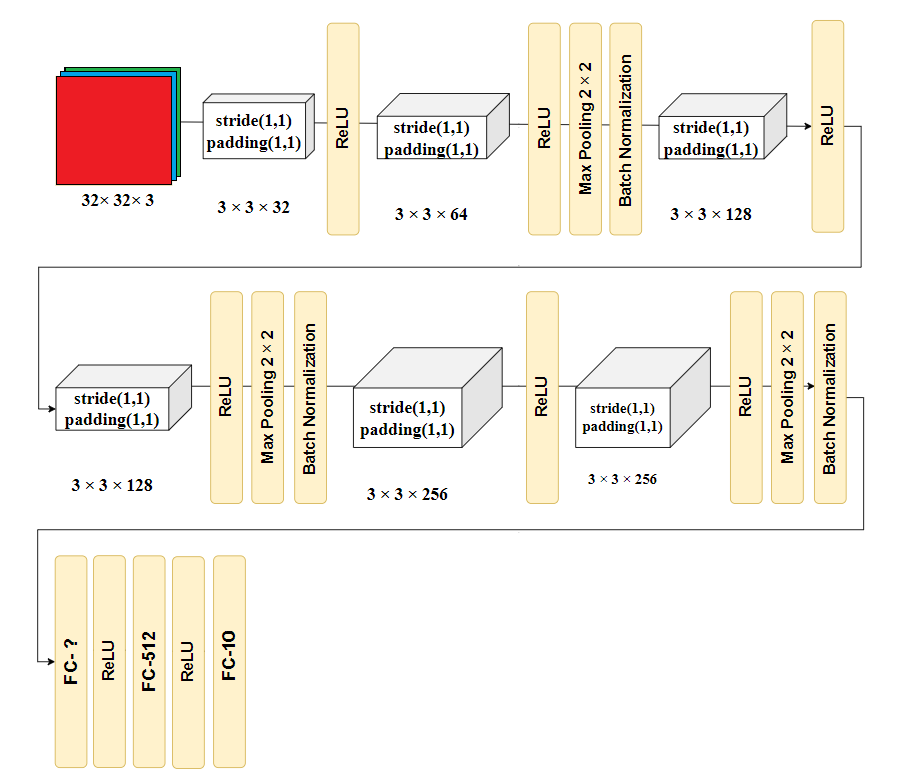

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, out_dim):
        """
        `in_channels`: Number of channels for input instances
        `out_dim`    : The network's output dimensions
        """
        super().__init__()
        self.relu = nn.ReLU()            # Apply for all the layers (except the last one)
        self.maxpool = nn.MaxPool2d(2,2) # Apply for conv2, conv4, and conv6
        
        self.bn1 = nn.BatchNorm2d(64) # Apply for conv2
        self.bn2 = nn.BatchNorm2d(128) # Apply for conv4
        self.bn3 = nn.BatchNorm2d(256) # Apply for conv6
        
        self.conv1 = self.conv2 = self.conv3 = self.conv4 = self.conv5 = self.conv6 = None
        self.fc1 = self.fc2 = self.fc3 = None

        
        # Create five 2D convolutional layers (conv1 through conv6)
        # Set the padding and stride to 1 for all the layers.
        # Use 3*3 kernels.
        ##############################
        # Your code goes here (10 points)
        self.conv1 = nn.Conv2d(in_channels, 32, (3, 3), (1, 1), (1, 1))
        self.conv2 = nn.Conv2d(32, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 128, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(128, 128, (3, 3), (1, 1), (1, 1))
        self.conv5 = nn.Conv2d(128, 256, (3, 3), (1, 1), (1, 1))
        self.conv6 = nn.Conv2d(256, 256, (3, 3), (1, 1), (1, 1))
        ##############################

        self.flatten = nn.Flatten()
        
        # According to the output dimensions of `conv6` and the `in_features` value for fc2,
        # set `in_features` and `out_features` for fc1 to proper values. 
        ##############################
        # your code goes here (5 points)
        self.fc1 = nn.Linear(4*4*256, 1024)
        #############################
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, out_dim)
        
    def forward(self, x):
        # Move x thorugh the network and return the output
        # according to the architecture.
        ##############################
        # Your code goes here (10 points)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.bn1(self.maxpool(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.bn2(self.maxpool(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.bn3(self.maxpool(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        ##############################
        return out

In [12]:
model = SimpleCNN(3, 10).to(device=device)
model

SimpleCNN(
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out

In [13]:
from prettytable import PrettyTable

def count_parameters(model):
  table = PrettyTable(["Parameters name", "Parameters Shape", "Parameters number"])
  t_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    param_shape = parameter.shape
    param = parameter.numel()
    table.add_row([name, param_shape, param])
    t_params += param
  print(table)
  print(f"Sum of trained paramters: {t_params}")
  
count_parameters(model)

+-----------------+------------------------------+-------------------+
| Parameters name |       Parameters Shape       | Parameters number |
+-----------------+------------------------------+-------------------+
|    bn1.weight   |       torch.Size([64])       |         64        |
|     bn1.bias    |       torch.Size([64])       |         64        |
|    bn2.weight   |      torch.Size([128])       |        128        |
|     bn2.bias    |      torch.Size([128])       |        128        |
|    bn3.weight   |      torch.Size([256])       |        256        |
|     bn3.bias    |      torch.Size([256])       |        256        |
|   conv1.weight  |  torch.Size([32, 3, 3, 3])   |        864        |
|    conv1.bias   |       torch.Size([32])       |         32        |
|   conv2.weight  |  torch.Size([64, 32, 3, 3])  |       18432       |
|    conv2.bias   |       torch.Size([64])       |         64        |
|   conv3.weight  | torch.Size([128, 64, 3, 3])  |       73728       |
|    c

In [14]:
# Use Adam optimizer with a learning rate of 0.001 as the optimizer.
# Use CrossEntropy as loss function.
##############################
# Your code goes here (5 points)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
##############################
train(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader=val_loader
)

Epoch 1, Training loss 2.141238349314315, Validation loss 0.9237833656842196
Epoch 2, Training loss 1.491355160554758, Validation loss 0.8027471153041984
Epoch 3, Training loss 1.2773693563839117, Validation loss 0.7326057489159741
Epoch 4, Training loss 1.1586058575886127, Validation loss 0.6897121128402178
Epoch 5, Training loss 1.0842129692863733, Validation loss 0.6448644309104243
Epoch 6, Training loss 1.0283742733656789, Validation loss 0.6056605886809433
Epoch 7, Training loss 0.9815633670209696, Validation loss 0.6113044332854355
Epoch 8, Training loss 0.9430230389387844, Validation loss 0.6159716399410103
Epoch 9, Training loss 0.9228535424025295, Validation loss 0.6232797907123083
Epoch 10, Training loss 0.8973292485593607, Validation loss 0.6260684272156486


In [15]:
test(model, test_loader)

0.8027

## Visualizing Feature Maps

The feature maps, also known as activation maps, record what happens when the filters are applied to an input.


In this section, you're going to visualize feature maps for a random input image for layers `conv1` through `conv6`. 

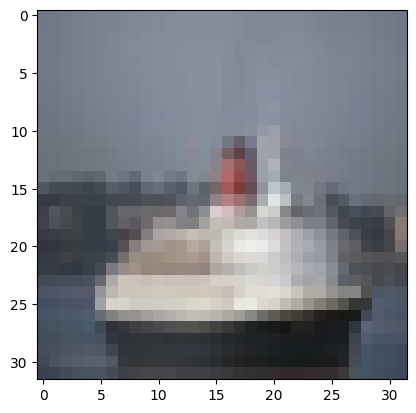

In [17]:
import random
img = train_set[random.randint(0, len(train_set))][0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [18]:
conv_layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6]

# Pass `img` thorough the layers and save the results for each layer in `output`.
##############################
# Your code goes here (5 points)
outputs = []
img = img.to(device)
x = img
for layer in conv_layers:
  x = layer(x)
  outputs.append(x)
##############################
len(outputs)

6

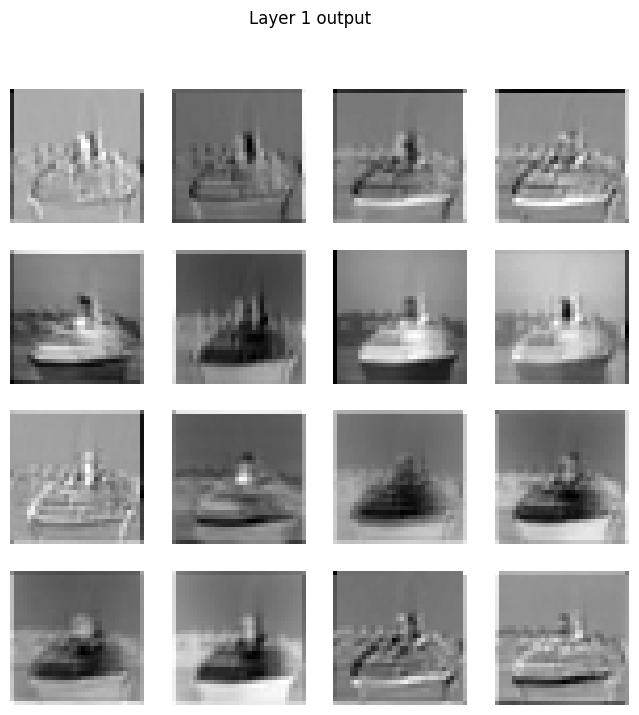

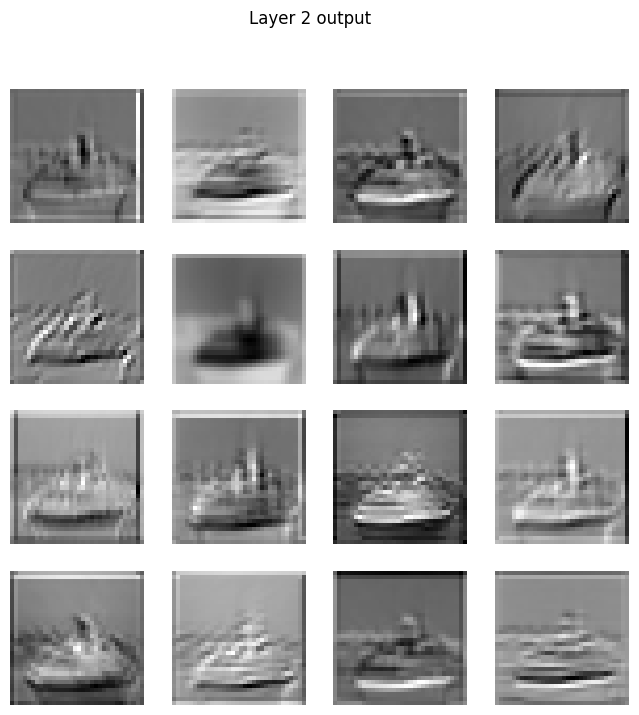

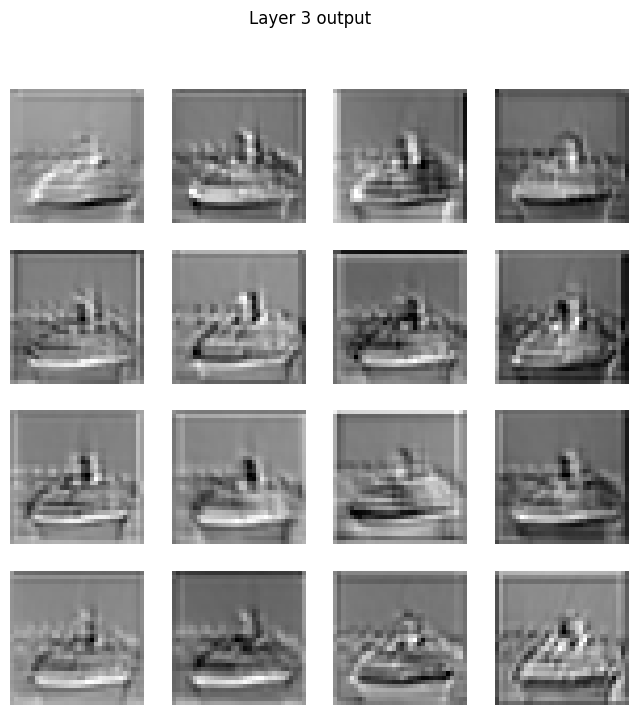

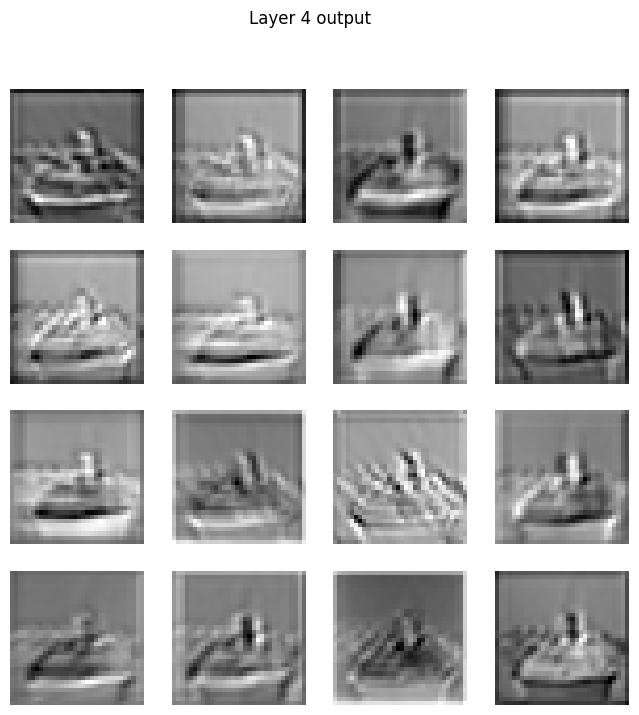

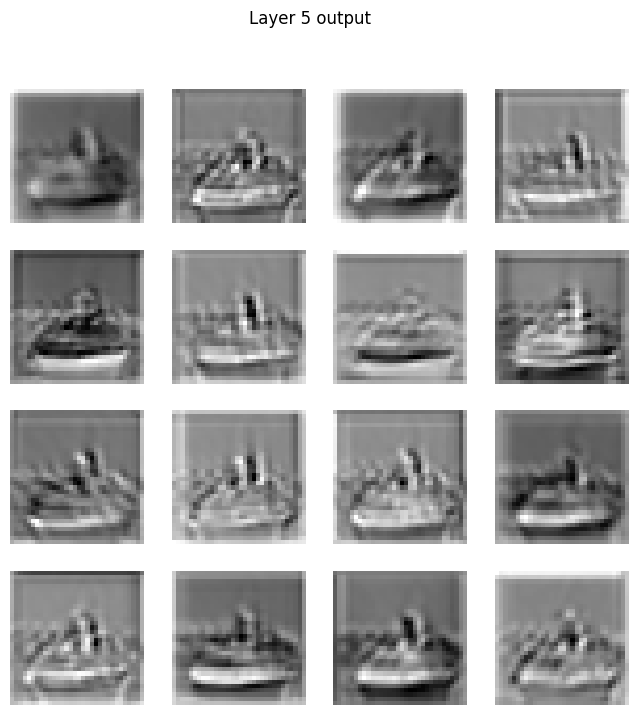

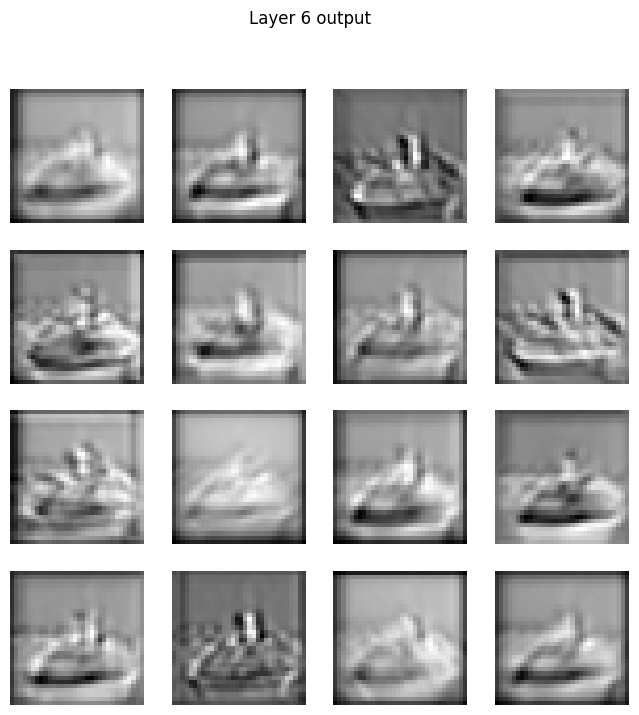

In [19]:
# Visualize the output for the first 16 filters of each layer.
##############################
# Your code goes here (5 points)
for i, layer_output in enumerate(outputs):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
    for j in range(16):
        axs[j // 4, j % 4].imshow(layer_output[j:j+1, :, :].permute(1,2,0).detach().cpu(), cmap='gray')
        axs[j // 4, j % 4].axis('off')
    plt.suptitle(f'Layer {i+1} output')
    plt.show()
##############################

**Answer the following question (5 points):**
- Which one of the feature maps you visualized do you find helpful for the task? Which ones you don't find helpful?

Early layers (e.g., conv1 and conv2) tend to capture low-level features such as edges and corners. Later layers (e.g., conv5 and conv6) tend to capture higher-level features such as object parts and textures. For the task of CIFAR classification, both types of features can be important. Low-level features can help to distinguish between different shapes and textures, while higher-level features can help to identify specific objects or object classes